## Pre-processing, feature engineering and modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#Get cleaned datasets: Not touching main test set first
test = '../datasets/test_cleaned.csv'
train = '../datasets/train_cleaned.csv'

In [3]:
# Read csv the clean files
test = pd.read_csv(test)
train = pd.read_csv(train)
train.drop('Unnamed: 0',axis = 1,inplace=True)
test.drop('Unnamed: 0',axis = 1,inplace=True)
# Combine train and test scores first
df = pd.concat([test,train],ignore_index=True,sort=False)

In [4]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,2658,902301120,190,RM,69.0,9142,0,Grvl,3,Lvl,...,0,0,0,0,None,0,4,2006,WD,NaN
1,2718,905108090,90,RL,0.0,9662,0,None,2,Lvl,...,0,0,0,0,None,0,8,2006,WD,NaN
2,2414,528218130,60,RL,58.0,17104,0,None,2,Lvl,...,0,0,0,0,None,0,9,2006,New,NaN
3,1989,902207150,30,RM,60.0,8520,0,None,3,Lvl,...,0,0,0,0,None,0,7,2007,WD,NaN
4,625,535105100,20,RL,0.0,9500,0,None,2,Lvl,...,185,0,0,0,None,0,7,2009,WD,NaN


In [5]:
# Combining features in continuous and discrete columns
# Looking at the overall bathroom facilities available and interaction between bedroom and bathrooms
df['total_bathrooms'] = df['Bsmt Full Bath'] + df['Bsmt Half Bath']*0.5 + df['Full Bath'] + df['Half Bath']*0.5
# Looking at the total porch SF available
df['porch_sf'] = df['Wood Deck SF'] + df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch']
# Looking at the age of house when sold since last remodification
df['age'] = df['Yr Sold'] - df['Year Remod/Add']
# Fireplace score per fireplace
df['fire_score'] = df['Fireplaces'] * df['Fireplace Qu']
# Ease of parking based on slope and on pavement
df['parking'] = (df['Paved Drive'] + 1) * (df['Land Slope'] + 1)

In [6]:
# MS Subclass should be nominal
df['MS SubClass'] = df['MS SubClass'].astype(str)

In [7]:
# Based on domain knowledge, the following features might be considered to be strong predictors of sale price
features = ['Gr Liv Area','porch_sf','total_bathrooms','Bedroom AbvGr','age','Utilities','Functional','Lot Area',
            'Garage Qual','Garage Finish','Bsmt Qual','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Overall Qual','fire_score','parking',
            'TotRms AbvGrd','Neighborhood','MS SubClass','MS Zoning','Foundation','Lot Shape', 'Exter Qual','Heating QC','Electrical',
            'Pool QC','Fence','Mas Vnr Area']
features_target = features + ['SalePrice']

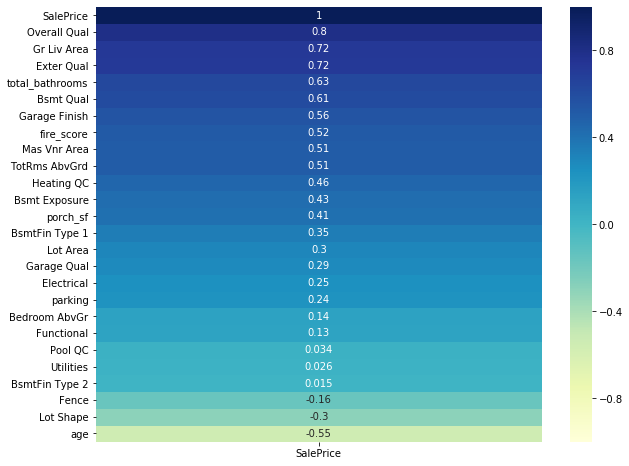

In [8]:
# Explore correlation to target:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df[features_target].corr()[['SalePrice']].sort_values('SalePrice'),
            vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

In [9]:
features = [col for col in features if col not in ('Overall Qual','Gr Liv Area', 'Exter Qual')]

## High correlation with target:

We see that Overall quality, Gr Liv Area and Exter Qual have a strong correlation with the target value >0.7, and I would want to drop these feature. The rest of the correlation seems to be reasonable.

In [10]:
# Explore multi-collinearity:
corr = df[features].corr().abs()
unstack_corr = corr.unstack()
corr_sort = unstack_corr.sort_values(ascending = False)

print(corr_sort[20:30])

Pool QC          Pool QC            1.000000
porch_sf         porch_sf           1.000000
TotRms AbvGrd    Bedroom AbvGr      0.679696
Bedroom AbvGr    TotRms AbvGrd      0.679696
age              Heating QC         0.546850
Heating QC       age                0.546850
Bsmt Qual        age                0.525816
age              Bsmt Qual          0.525816
Bsmt Qual        total_bathrooms    0.493552
total_bathrooms  Bsmt Qual          0.493552
dtype: float64


## High correlation with each other:

The general correlation between each feature seems acceptable as they are less than 0.7.

In [11]:
# Define the feature
X = df[features]

In [12]:
# Create dummies for nominal features
X = pd.get_dummies(X, drop_first = True)

In [13]:
# Important to split out the train and test set here, and only use the train set for modeling.
# Add back the sale price column to the polynomial feature dataframe
X = pd.concat([X,df['SalePrice']],axis = 1)
# Add back the ID column for test submission at the end
X = pd.concat([X,df['Id']],axis = 1)

In [14]:
# split out the test and the train set manually 
test = X[X['SalePrice'].isnull()]
X = X[X['SalePrice'].notnull()]

In [15]:
# Separate out the target train and test sets
y = X['SalePrice']
# remove the target column in train set
X.drop(columns='SalePrice',inplace = True)

## Train test split, standardizing and modeling with Linear regression, Lasso and Ridge

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

## Standardizing

In [17]:
# Standardizing
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train = stdsc.transform(X_train)
X_test = stdsc.transform(X_test)

## Linear Regression

In [18]:
# Assume linear regression as target is continuous variable
linreg = LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# Linear regression metrics
print("LR cross_val_score", cross_val_score(linreg, X_train, y_train, cv=5).mean())
print('LR train r2 =', linreg.score(X_train, y_train))
print('LR test r2 =', linreg.score(X_test, y_test))
mse = mean_squared_error(y_test, linreg.predict(X_test))
print('LR MSE =', mse)

LR cross_val_score -6.7803803169653025e+22
LR train r2 = 0.8522624404547277
LR test r2 = -2.585174950869936e+24
LR MSE = 1.5420543274352975e+34


## LassoCV model

In [20]:
lasso = LassoCV(n_alphas=2000,cv=5,n_jobs=-1)
lasso.fit(X_train,y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=2000, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [21]:
# Lasso metrics
print('Lasso train r2 =', lasso.score(X_train, y_train))
print('Lasso test r2 =', lasso.score(X_test, y_test))
mse = mean_squared_error(y_test, lasso.predict(X_test))
print('Lasso MSE =', mse)

Lasso train r2 = 0.8506755422993247
Lasso test r2 = 0.8395398948925361
Lasso MSE = 957142956.1408296


## RidgeCV model

In [22]:
ridge = RidgeCV(alphas=np.linspace(.01, 100, 2000))
ridge.fit(X_train,y_train)

RidgeCV(alphas=array([1.0000000e-02, 6.0020010e-02, 1.1004002e-01, ..., 9.9899960e+01,
       9.9949980e+01, 1.0000000e+02]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [23]:
print('Ridge train r2 =', ridge.score(X_train, y_train))
print('Ridge test r2 =', ridge.score(X_test, y_test))
mse = mean_squared_error(y_test, ridge.predict(X_test))
print('Ridge MSE =', mse)

Ridge train r2 = 0.8517864007040881
Ridge test r2 = 0.8385818516025021
Ridge MSE = 962857674.9871116


## Model comparison

As comparing between the train set and the test set, we see that the difference is highest in linear regression as it is not regularised. Also, the mean square error is highest in this model. However, after regularisation, we see that the difference between r2 in test and train set is much smaller. More distictively, in the lassoCV model, we see that the model has high generalisability with r2 in train and test set of >0.84

## Inferential Visualizations and business recommendations

In [24]:
coef = pd.Series(lasso.coef_, index = (X.columns))

Text(0.5, 1.0, 'Feature importance using Lasso Model')

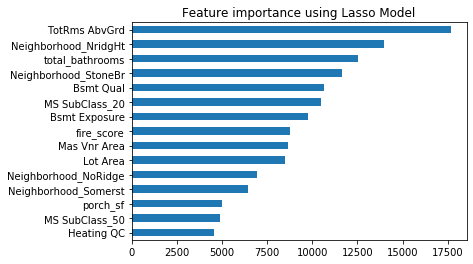

In [25]:
# Positively impacting features sorted
imp_coef = coef.sort_values().tail(15)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Looking at the coefficients of the features in the LassoCV model, it is not surprising to see that the total number of rooms matter in the sale price of the Ames house. This is also relavant to the number of total bathrooms both basement and above ground. Total number of rooms and facilities correlate with the overall square feet of the house and thus the larger the square feet, the more expensive the house would be. There is however a strong point for houses built in certain neighbourhoods, for example North Ridge Heights and also Stone Brooks. We do see from our previous plot in EDA that by neighbourhoor, these 2 neighbourhoods are actually the highest in median sale price with the highest price variance.

Interestingly, the fire_score also proved to be a strong factor in predicting sale prices. This is somewhat unexpected since one would likely to choose utilities, central air, heating quality etc over fireplace. The preference over fireplace than modern methods of heating might be again assigned to the affluent, who prefer to enjoy the finer things in life.

Text(0.5, 1.0, 'Feature that hurt sale prices using Lasso Model')

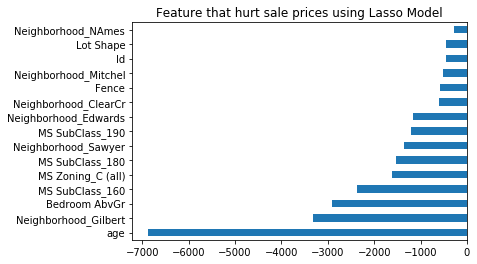

In [26]:
# Negatively impacting features sorted
neg_coef = coef.sort_values().head(15)
neg_coef.plot(kind = "barh")
plt.title("Feature that hurt sale prices using Lasso Model")

# Recommendations and business inferences

As expected, as the age of the house since its last remodelling time, the lower the sale price, as premium would often go to those houses that are newly renovated. As do the housing subclass of 120 and 160, which showcase houses from planned unit development from 1946 onwards. Sale prices also further depreciate when the shape of the lot which the house is built on becomes more irregular. 

Perhaps, to further improve the model, we could also look at interaction between lot shape and neighbourhood. This might be interesting because houses build around expensive neighbourhoods can sometimes be more irregular than houses built on flat land. We see houses built on hills or ridges have to follow the slope contours to provide strong foundation for the house. This lot shape and neighbourhood interaction might prove to complement or contradict the current direction of lot shape feature on sale price.

## Submission of scores

In [27]:
test.drop(columns='SalePrice',inplace = True)

In [29]:
# Get predicted scores from our model above
predict = lasso.predict(test)
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice':predict
})

In [37]:
submission.head()

,Id,SalePrice
0,2658,7.728039e+07
1,2718,8.188104e+07
2,2414,1.451785e+08
3,1989,7.266920e+07
4,625,8.397066e+07


In [30]:
submission.to_csv('../datasets/submissions.csv', index=False)

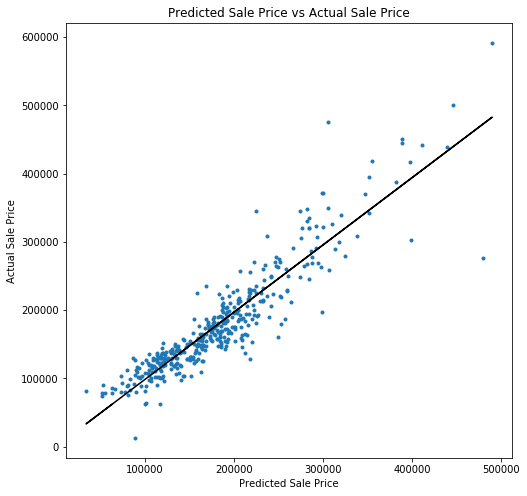

In [31]:
#plt.scatter(x=lasso_overfit_preds, y=y_test, c='r')
plt.figure(figsize=(8,8))
m,b = np.polyfit(x=lasso.predict(X_test), y=y_test, deg=1)
plt.plot(lasso.predict(X_test), y_test, '.')
plt.plot(lasso.predict(X_test), b + m * lasso.predict(X_test), '-', color='k')
frame1 = plt.gca()
#frame1.axes.get_xaxis().set_ticks([])
#frame1.axes.get_yaxis().set_ticks([])
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.title('Predicted Sale Price vs Actual Sale Price')
plt.show()